# Create test dataframe

In [1]:
import pandas as pd
from time import sleep
from os import environ
from data.get_data import DataFactory
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from indicators.indicators import IndicatorFactory

# Set environment variable
environ["ENV"] = "development"
# Set dataframe dict
dfs = dict()
# Set list of available exchanges, cryptocurrencies and tickers
exchanges = {'Binance': {'BTCUSDT': ['5m']}}
# Get configs
configs = ConfigFactory.factory(environ).configs

# For every exchange, ticker and timeframe in base get cryptocurrency data and write it to correspond dataframe
for exchange in exchanges:
    exchange_api = DataFactory.factory(exchange)
    tickers = exchanges[exchange]
    for ticker in tickers:
        timeframes = tickers[ticker]
        for timeframe in timeframes:
            print(f'Exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
            # If all cryptocurrencies signal stat is in dataframe dict - get it, else create new
            total_stat = dfs.get('total_stat', pd.DataFrame())
            # If cryptocurrency dataframe and it's signal stat is in dataframe dict - get it,
            # else - create the new ones
            df, stat = dfs.get(f'{ticker}_{timeframe}', (pd.DataFrame(), pd.Series()))
            # If dataframe is empty - get all available data to fill it,
            # else - just get necessary for update data
            if df.shape == (0, 0):
                interval = configs['Interval']['creation_interval']
            else:
                interval = configs['Interval']['update_interval']
            # Write data to the dataframe
            df = exchange_api.get_data(df, ticker, timeframe, interval)
            # Create indicator list
            indicator_list = configs['Indicator_list']
            indicators = list()
            for indicator in indicator_list:
                indicators.append(IndicatorFactory.factory(indicator, configs))
            # Write indicators to dataframe
            df = exchange_api.add_indicator_data(df, indicators, ticker, timeframe)
            # Save dataframe to the disk
            df.to_pickle('df.pkl')
            # Update dataframe dict
            dfs[f'{ticker}_{timeframe}'] = df
            # Get signal
            fs = FindSignal(configs)
            points = fs.find_signal(df)
            # Save dataframe to the disk
            df.to_pickle('df.pkl')

Exchange is Binance, ticker is BTCUSDT, timeframe is 5m


/tmp/ipykernel_14477/1121120486.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df, stat = dfs.get(f'{ticker}_{timeframe}', (pd.DataFrame(), pd.Series()))


## Plot STOCH values

[(85, 6.229579019335869)]

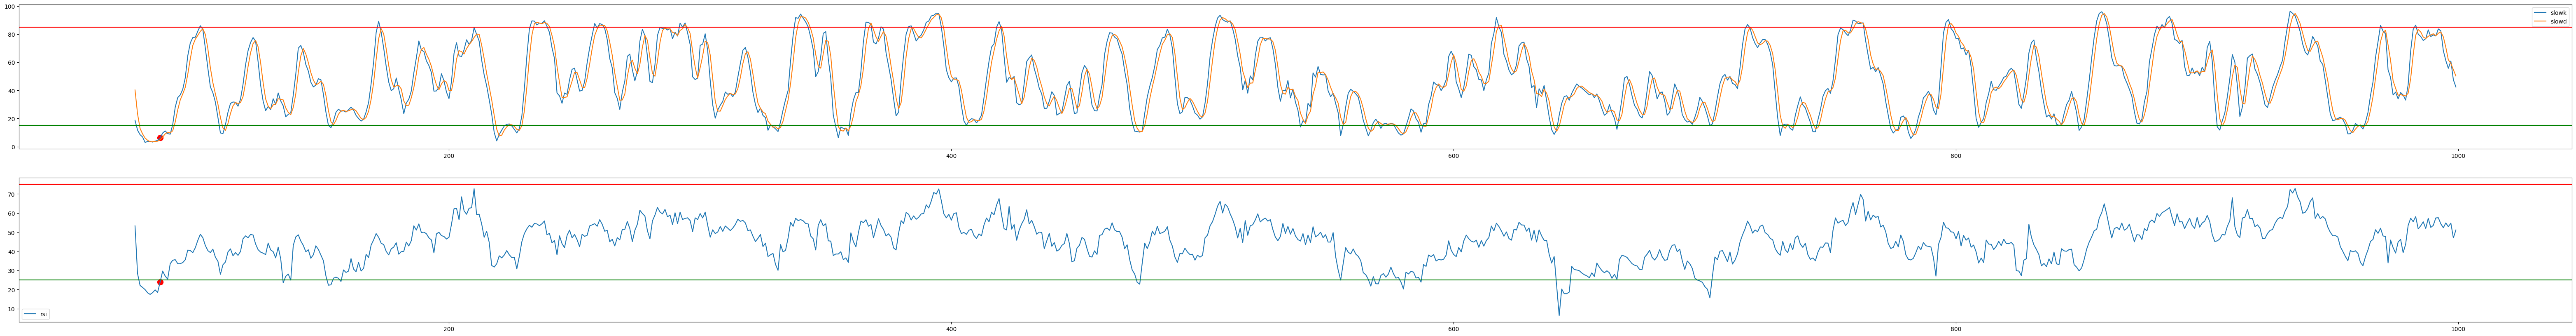

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from os import environ
from config.config import ConfigFactory
from signals.find_signal import FindSignal

pd.set_option('display.max_rows', 500)

# Set environment variable
environ["ENV"] = "development"

configs = ConfigFactory.factory(environ).configs
df = pd.read_pickle('df.pkl')
fs = FindSignal(configs)
points = fs.find_signal(df)

# save signal points for visualization
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    scatter_stoch_points.append((point, df['stoch_slowk'].iloc[point]))
    scatter_rsi_points.append((point, df['rsi'].iloc[point]))
    
# subplots for STOCH and RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(80, 10))

# plot STOCH
ax1.plot(df.iloc[75:]['stoch_slowk'])
ax1.plot(df.iloc[75:]['stoch_slowd'])
# show bounders
ax1.axhline(y=15, color='g', linestyle='-')
ax1.axhline(y=85, color='r', linestyle='-')
leg = ax1.legend(['slowk', 'slowd'])

for point in scatter_stoch_points:
    ax1.scatter(point[0], point[1], s=100, color='red')

# plot RSI
ax2.plot(df.iloc[75:]['rsi'])
ax2.axhline(y=25, color='g', linestyle='-')
ax2.axhline(y=75, color='r', linestyle='-')
leg = ax2.legend(['rsi'])

for point in scatter_rsi_points:
    ax2.scatter(point[0], point[1], s=100, color='red')

scatter_stoch_points

In [3]:
df.iloc[75:95]

,time,open,close,high,low,volume,stoch_slowk,stoch_slowd,rsi,stoch_slowk_dir,stoch_slowd_dir,diff
75,2022-08-17 07:20:00,24331.57,24301.99,24348.26,24291.62,747.29171,18.696152,40.258629,53.286911,-0.528136,-0.331523,-11.758715
76,2022-08-17 07:25:00,24303.89,24056.12,24307.65,23975.00,3686.45599,11.725915,23.347990,28.353298,-0.372817,-0.420050,-14.049537
77,2022-08-17 07:30:00,24056.12,23919.77,24068.75,23911.57,2272.58070,8.471919,12.964662,22.160594,-0.277505,-0.444720,-14.195512
78,2022-08-17 07:35:00,23919.77,23890.41,23974.55,23880.01,1733.52464,6.854834,9.017556,21.092310,-0.190876,-0.304451,-12.088502
79,2022-08-17 07:40:00,23892.42,23857.99,23905.71,23823.00,2205.40780,2.992491,6.106415,19.948741,-0.563448,-0.322830,-8.590788
80,2022-08-17 07:45:00,23855.56,23808.42,23937.38,23785.92,2291.12329,3.616727,4.488017,18.313783,0.208601,-0.265032,-4.452551
81,2022-08-17 07:50:00,23806.88,23780.15,23845.57,23765.42,1321.91199,3.741318,3.450179,17.436110,0.034449,-0.231247,-2.069908
82,2022-08-17 07:55:00,23776.70,23786.42,23827.61,23759.30,1155.77550,3.214664,3.524236,18.370500,-0.140767,0.021465,-1.233274
83,2022-08-17 08:00:00,23788.32,23795.62,23825.13,23759.40,1385.75486,3.878703,3.611561,19.804641,0.206566,0.024779,-0.747301
84,2022-08-17 08:05:00,23795.62,23761.72,23796.62,23735.00,1337.38112,4.429418,3.840928,18.513900,0.141984,0.063509,-0.006819
